# W08 - Class Assignment
# Data Mining (Kamis)
W08 - 0706022310028 - Jevon Ivander K

# 1. Data Preparation & EDA

● Load the Wine Dataset from sklearn.datasets.

● Display basic information (.head(), .info(), .describe()).

● Perform data cleaning and binning/discretization (if necessary).

● Create at least two different visualizations (e.g., histograms, boxplots, heatmaps, scatterplots).

● Provide a brief explanation for each visualization (what patterns or differences do you
observe?).

Example: compare “alcohol” vs “color intensity” among classes

**Installation**

The main page for PRISM rules is from https://towardsdatascience.com/prism-rules-in-python-14d2cfd801a3/

In [42]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification, make_blobs, fetch_openml
import sklearn.datasets as datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype


class PrismRules:
    def __init__(self, min_coverage=10, min_prob=0.75, nbins=3, verbose=0):
        """
        Class to generate PRISM rules for a supplied dataset.

        :param min_coverage: The minimum number of rows each rule must cover.
        :param min_prob: The minimum probability for each rule. The target class must be the target value in the
            remaining rows (the rows not covered by previous rules) with at least this probability.
        :param nbins: The number of bins each numeric column is divided into.
        :param verbose: If 0, no output is produced other than the induced rules. If 1, progress indication is
            presented as each rule is induced.
        """

        self.min_coverage = min_coverage
        self.min_prob = min_prob
        self.nbins = nbins
        self.bin_ranges = {}
        self.verbose = verbose
        self.default_target = None
        self.predict_dict = {}
        self.target_column = ""

        # For improved performance, integer values are used for each value. This dictionary maps the integer codes
        # to the original values, and is used to display the rules and target values. Where the column is numeric,
        # this maps to the bin label.
        self.int_to_values_map = {}

    def __get_next_term(self, df, target_col, target_val, cols_exclude_list):
        """
        Get the next term (a column-value pair) for the current rule.

        :param df: The dataframe for the current rule. This is the set of rows matching the rule so far.
        :param target_col: Target column
        :param target_val: The current target value within the target column
        :param cols_exclude_list: Columns for which we already have terms for this rule.
        :return: a single term in tuple format, with a column name and value from that column, along with the
            probability and coverage (frequency) of the rule on the remaining rows.
        """

        max_prob = -1
        # In the event of ties with respect to probability, we take the term with the greatest frequency
        max_prob_freq = 0
        term = None
        for col_name in df.drop(columns=[target_col]).columns:
            if col_name in cols_exclude_list:
                continue
            for val in df[col_name].unique():
                sub_df_1 = df[df[col_name] == val]
                sub_df_2 = df[(df[col_name] == val) & (df[target_col] == target_val)]
                prob = len(sub_df_2) / len(sub_df_1)
                freq = len(sub_df_2)
                if freq < self.min_coverage:
                    continue
                if (prob > max_prob) or ((prob == max_prob) and (freq > max_prob_freq)):
                    max_prob = prob
                    max_prob_freq = freq
                    term = (col_name, val, prob, freq)
        return term

    def __get_next_rule(self, df_rule, target_col, target_val):
        """
        Given a specified target_val in the target_col, find the first or next rule. If not the first, the dataframe
        should just contain rows not covered by the previous rules for this target value.

        :param df_rule: the full original dataframe, minus the rows covered by other rules for the current target
        :param target_col: the target column
        :param target_val: the target value
        :return: a list of terms for the new rule, and a dataframe with the rows for this rule
        """

        terms_list = []
        cols_exclude_list = []  # Do not create terms for the same feature in the same rule
        df = df_rule.copy()
        target_val_remaining = df[target_col].tolist().count(target_val)
        len_df = len(df)
        while target_val_remaining < len_df:
            term = self.__get_next_term(df, target_col, target_val, cols_exclude_list)
            if term is None:
                break
            col, val, prob, freq = term
            cols_exclude_list.append(col)
            if len(cols_exclude_list) == (len(df.columns) - 1):
                break
            df = df[(df[col] == val)]
            terms_list.append((term, df))
            target_val_remaining = df[target_col].tolist().count(target_val)
            len_df = len(df)

        # Check the terms list for the optimal set of terms, which is the set with the highest probability of the
        # target class given the terms.
        max_prob = 0
        max_prob_idx = -1
        max_prob_df = None
        for term_idx, term in enumerate(terms_list):
            if term[0][2] > max_prob:
                max_prob = term[0][2]
                max_prob_idx = term_idx
                max_prob_df = term[1]
        optimal_terms_list = terms_list[:max_prob_idx + 1]
        optimal_terms_list = [x for x, y in optimal_terms_list]

        if max_prob < self.min_prob:
            return None, None

        # Convert the integer codes used in the dataframe to the original values for the relevant column
        formatted_terms = []
        for t in optimal_terms_list:
            if t[1] == "NONE":
                formatted_terms.append(t)
            else:
                formatted_terms.append((t[0], self.int_to_values_map[t[0]][t[1]], t[2], t[3]))

        return formatted_terms, max_prob_df

    def __get_rules_for_target_val(self, df_full, target_col, target_val):
        """
        Get the full set of rules for the specified value in the target column
        :param df_full:
        :param target_col:  Name of target column
        :param target_val:  Value in the target column for which this execution of this function generates rules.
        :return: array of strings.
        """

        rules_for_val = []
        num_rows_curr_target = df_full[target_col].tolist().count(target_val)
        df = df_full.copy()  # Create a temporary dataframe that shrinks as the rules are formed
        is_first_rule = True
        target_val_remaining = df[target_col].tolist().count(target_val)
        while target_val_remaining > self.min_coverage:
            if self.verbose:
                print(f"  Determining next rule. {target_val_remaining:,} rows remaining for target class")
            num_rows_curr_target_remaining = df[target_col].tolist().count(target_val)
            terms_list, rule_df = self.__get_next_rule(df, target_col, target_val)
            if not terms_list:
                break

            if target_val in self.predict_dict:
                self.predict_dict[target_val].append(terms_list)
            else:
                self.predict_dict[target_val] = [terms_list]

            # Add a rule in string format representing the list of terms returned
            rule_str = ""
            for term in terms_list:
                rule_str += str(term[0]) + " = " + str(term[1]) + " AND "
            rule_str = rule_str[:-5]  # Remove the trailing "AND"
            num_matching_target = rule_df[target_col].tolist().count(target_val)
            rule_str += "\n   Support:  "
            if is_first_rule:
                rule_str += f"the target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} rows matching the rule "
                rule_str += "\n   Coverage: "
                rule_str += f"the rule matches: {num_matching_target} out of {num_rows_curr_target} rows "
                rule_str += f"for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
            else:
                rule_str += f"The target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} remaining rows matching the "
                rule_str += "rule"
                rule_str += "\n   Coverage: "
                rule_str += f"The rule matches: {num_matching_target} out of {num_rows_curr_target_remaining} rows "
                rule_str += f"remaining for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
                rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target_remaining):.3f}% of "
                rule_str += f"remaining rows for target value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target):.3f}% of total rows for target "
            rule_str += f"value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / len(df_full)):.3f}% of total rows in data"
            rules_for_val.append(rule_str)
            is_first_rule = False

            # Remove all rows for this rule
            df = df.loc[list(set(df.index) - set(rule_df.index))]
            target_val_remaining = df[target_col].tolist().count(target_val)
        return rules_for_val

    def __display_rules(self, df, target_col, rules_dict, display_stats):
        for target_val in rules_dict:
            print()
            print('........................................................................')
            print(f"Target: {self.int_to_values_map[target_col][target_val]}")
            print('........................................................................')
            if len(rules_dict[target_val]) == 0 and display_stats:
                print((f"  No rules imputed for target value {self.int_to_values_map[target_col][target_val]}. There "
                       f"are {df[target_col].tolist().count(target_val)} rows for this class."))
            for r in rules_dict[target_val]:
                if display_stats:
                    print(r)
                else:
                    print(r.split("\n")[0])

    def get_prism_rules(self, df, target_col, display_stats=True):
        """
        Given a dataframe with a specified target column, find a set of rules that describe the patterns associated
        with the target column. The rules are displayed in a formatted form.

        :param df: pandas dataframe. Must include the target column.
        :param target_col: Name of the target column
        :param display_stats: If True, the support and coverage for each rule will be displayed
        :return: array of strings, with each element of the array representing one rule.
        """

        # PRISM requires all columns be categorical, so bin any numeric features, including the target column if
        # necessary.
        new_vals_dict = {}
        for col_name in df.columns:
            if is_numeric_dtype(df[col_name]) and (df[col_name].nunique() > 10):
                try:
                    if self.nbins == 3:
                        vals = ['Low', "Med", 'High']
                        bin_ids, bin_ranges = pd.qcut(df[col_name], 3, labels=vals, retbins=True)
                    else:
                        vals = [f"Bin_{x}" for x in range(self.nbins)]
                        bin_ids, bin_ranges = pd.qcut(df[col_name], self.nbins, labels=vals, retbins=True)
                    self.bin_ranges[col_name] = bin_ranges
                    vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                    int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                    new_vals_dict[col_name] = bin_ids.map(vals_to_int_map)
                    self.int_to_values_map[col_name] = int_to_vals_map
                except:
                    # The qcut() method may fail if the data is sufficiently skewed, and the bins are non-unique, In
                    # this case we do not include the column in the model.
                    pass
            else:
                vals = df[col_name].unique()
                vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                new_vals_dict[col_name] = df[col_name].map(vals_to_int_map)
                self.int_to_values_map[col_name] = int_to_vals_map
        df = pd.DataFrame(new_vals_dict)

        # Remove any columns with only 1 unique value
        drop_cols = []
        for col_name in df.columns:
            if df[col_name].nunique() < 2:
                drop_cols.append(col_name)
        df = df.drop(columns=drop_cols)

        # Fill any NaN and None values
        for col_name in df.columns:
            if df[col_name].dtype.name == "category":
                df[col_name] = df[col_name].cat.add_categories("NONE").fillna("NONE")
            else:
                df[col_name] = df[col_name].fillna("NULL")

        # Loop through each value in the target column and find the set of rules for this value
        target_vals = sorted(df[target_col].unique())
        if self.verbose:
            print(f"Determining rules for each of {len(target_vals)} target classes:")
        rules_dict = {}
        for target_val in target_vals:
            if self.verbose >= 1:
                print(f"Determining rules for target class: {self.int_to_values_map[target_col][target_val]}")
            rules_dict[target_val] = self.__get_rules_for_target_val(df, target_col, target_val)

        self.__display_rules(df, target_col, rules_dict, display_stats)

        self.default_target = df[target_col].mode().values[0]
        self.target_column = target_col

        return rules_dict

    def predict(self, X_in, leave_unknown=False):
        X = X_in.copy()
        X = X.reset_index(drop=True)
        if leave_unknown:
            ret = ["NO PREDICTION"]*len(X)
        else:
            ret = [self.default_target]*len(X)
        is_set = [False]*len(X)

        for col_name in X.columns:
            if col_name not in self.bin_ranges:
                continue
            bin_ranges = self.bin_ranges[col_name]
            for i in range(len(X)):
                v = X.loc[i, col_name]
                for bin_idx, bin_limit in enumerate(bin_ranges):
                    if v < bin_limit:
                        X.loc[i, col_name] = bin_idx - 1
                        break
            if col_name in self.int_to_values_map:
                X[col_name] = X[col_name].map(self.int_to_values_map[col_name])

        for i in range(len(X)):
            row = X.iloc[i]
            found_rule = False
            for key in self.predict_dict.keys():
                rules = self.predict_dict[key]
                for rule in rules:
                    all_terms_true = True
                    for term in rule:
                        term_feature_name = term[0]
                        term_value = term[1]
                        if row[term_feature_name] != term_value:
                            all_terms_true = False
                            break
                    if all_terms_true:
                        ret[i] = key
                        is_set[i] = True
                        found_rule = True
                        break
                if found_rule:
                    break
        ret = pd.Series(ret).map(self.int_to_values_map[self.target_column])
        if leave_unknown:
            ret = ret.fillna("NO PREDICTION")
            ret = ret.astype(str)
        return ret

    def get_bin_ranges(self):
        if self.bin_ranges is None:
            print("No columns were binned.")
        else:
            return self.bin_ranges


In [43]:
# load dataset
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/wine_data.csv"
df = pd.read_csv(url)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
0,13.73,1.50,2.70,22.5,101.0,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285.0,0
1,14.13,4.10,2.74,24.5,96.0,2.05,0.76,0.56,1.35,9.20,0.61,1.60,560.0,2
2,12.16,1.61,2.31,22.8,90.0,1.78,1.69,0.43,1.56,2.45,1.33,2.26,495.0,1
3,13.07,1.50,2.10,15.5,98.0,2.40,2.64,0.28,1.37,3.70,1.18,2.69,1020.0,0
4,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0


ensure all data is entered into the table and is in the correct format.

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  Y    

There is no missing value, but for unknown value we must check it using unique values

In [45]:
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [46]:
# show unique values from dataset
unique_values = {col: df[col].unique() for col in df.columns}
display(unique_values)

{'alcohol': array([13.73, 14.13, 12.16, 13.07, 13.16, 11.76, 12.08, 13.75, 13.78,
        12.58, 13.32, 13.88, 11.65, 13.58, 14.21, 12.37, 13.72, 13.36,
        13.41, 13.11, 12.29, 11.45, 12.42, 14.38, 14.39, 13.3 , 13.52,
        11.84, 12.25, 12.22, 12.  , 12.51, 11.82, 12.17, 14.34, 12.77,
        13.49, 12.52, 13.71, 13.5 , 11.81, 13.83, 12.84, 11.96, 12.72,
        12.43, 13.48, 11.62, 13.68, 12.45, 11.79, 13.82, 13.05, 13.9 ,
        13.45, 13.2 , 12.93, 11.03, 12.47, 13.4 , 12.7 , 12.21, 13.63,
        13.62, 14.23, 12.79, 13.17, 12.96, 13.86, 12.6 , 12.07, 13.24,
        12.87, 12.33, 13.87, 13.28, 13.56, 12.53, 13.03, 12.04, 11.61,
        14.1 , 11.46, 13.74, 12.34, 13.29, 14.06, 13.27, 13.64, 13.94,
        14.75, 12.82, 13.23, 13.51, 12.86, 13.67, 12.64, 12.85, 13.39,
        11.64, 12.36, 14.22, 14.12, 14.19, 13.76, 13.08, 11.41, 14.37,
        12.69, 12.2 , 13.69, 14.3 , 11.66, 14.83, 12.99, 13.84, 12.67,
        13.77, 11.87, 14.02, 12.88, 13.34, 11.56, 12.81, 14.16, 14

In [47]:
df = df.sample(n=len(df)) # Shuffle the rows
print("Number of rows:", len(df))

Number of rows: 178


The df.info() output shows that there are no missing values, so data cleaning in terms of handling missing data is not necessary. Also after I check the unique values, there is not uknown values so it is safe.


The PrismRules class provided handles the binning (discretization) of numerical features internally as part of its rule generation process. It automatically identifies numeric columns and divides them into a specified number of bins (nbins). This is done to convert numeric data into categorical data, which is required by the PRISM algorithm.



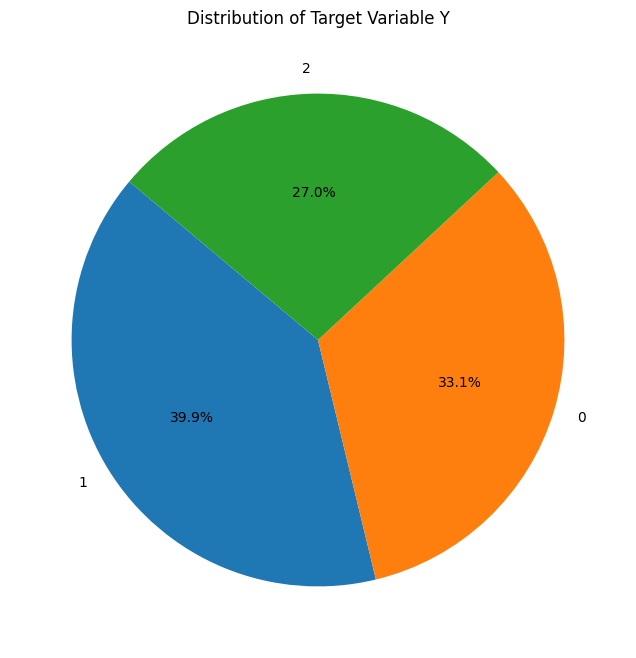

In [48]:
# Get the counts of each unique value in the 'Y' column
y_counts = df['Y'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(y_counts, labels=y_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Target Variable Y')
plt.show()

**Distribution of Target Variable Y:**

This pie chart shows the proportion of each class (0, 1, and 2) in the dataset. We can see that the classes are relatively balanced, with class 1 having the highest representation, followed by class 0 and then class 2. This information is helpful for understanding the class distribution before building a classification model.

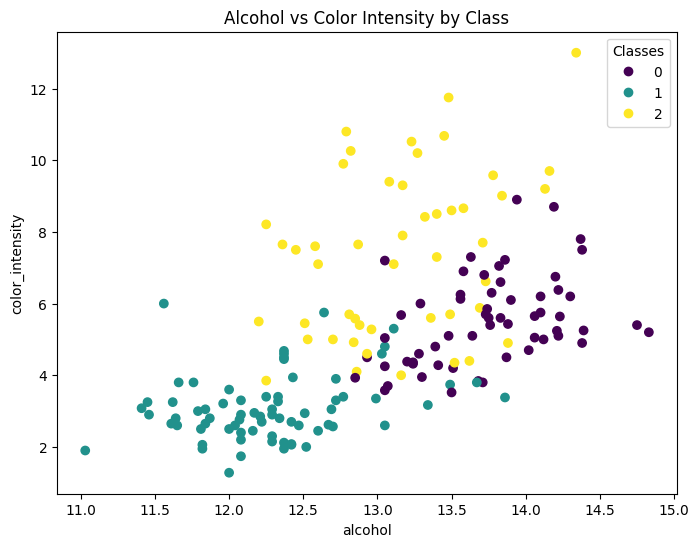

In [49]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['alcohol'], df['color_intensity'], c=df['Y'], cmap='viridis')
plt.xlabel('alcohol')
plt.ylabel('color_intensity')
plt.title('Alcohol vs Color Intensity by Class')
legend = plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()

**Alcohol vs Color Intensity by Class:**

This scatter plot visualizes the relationship between 'alcohol' and 'color_intensity' for each wine class. We can observe some separation between the classes based on these two features. For example, wines in Class 2 tend to have higher color intensity, while wines in Class 0 and 1 show more overlap but with some tendency for Class 0 to have higher alcohol.

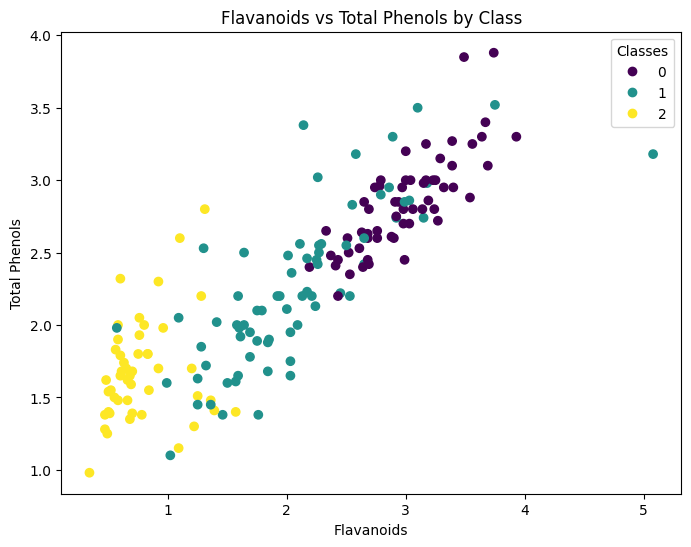

In [50]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['flavanoids'], df['total_phenols'], c=df['Y'], cmap='viridis')
plt.xlabel('Flavanoids')
plt.ylabel('Total Phenols')
plt.title('Flavanoids vs Total Phenols by Class')
legend = plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()

**Flavanoids vs Total Phenols by Class:**

This scatter plot shows the relationship between 'flavanoids' and 'total_phenols' for each wine class. Similar to the previous plot, there appears to be a good separation between the classes based on these two features. Wines in Class 0 generally have higher values for both flavanoids and total phenols, while Class 2 wines tend to have lower values for both. Class 1 wines are mostly in between, with some overlap with the other classes. These features seem to be quite discriminative for the wine classes.

# 2. Apply PRISM Algorithm

● Use the given PrismRules function to generate classification rules from the datasetand divide how much data you will use as a training test.

● Clearly display the generated rules in your notebook.

● Provide interpretation for each rule:

* What does the rule mean?

* What class does it represent?

* How strong or specific is the rule based on support and coverage?

Example explanation: “If alcohol is High and color_intensity is Low → class 1,
meaning wines with strong alcohol but lighter color tend to belong to class 1.”


In [51]:
total_data = len(df)
train_size = int(total_data * 0.8)
test_size = total_data - train_size

print(f"Total data: {total_data}")
print(f"Training data (80%): {train_size}")
print(f"Testing data (20%): {test_size}")

Total data: 178
Training data (80%): 142
Testing data (20%): 36


142 rows of data are used as training data because this represents 80% of the total available data. I use a 80:20 split for training and testing.

In [52]:
# since we dont do any partitioning bcs we have to use both X and Y in our 'prism' model, so let's just use 142 rows for this training and the rest for the testing

# PRISM requires all columns be categorical, so bin any numeric features, including the target column if necessary, BUT there's a binning function in 'get_prism_rules', so we dont need to binning it manually first.

prism = PrismRules()
_ = prism.get_prism_rules(df.head(142), 'Y')


........................................................................
Target: 2
........................................................................
flavanoids = Low AND color_intensity = Med
   Support:  the target has value: '2' for 100.000% of the 14 rows matching the rule 
   Coverage: the rule matches: 14 out of 39 rows for target value: '2'. This is:
      35.897% of total rows for target value: '2'
      9.859% of total rows in data
od280/od315_of_diluted_wines = Low AND color_intensity = High AND hue = Low
   Support:  The target has value: '2' for 100.000% of the 24 remaining rows matching the rule
   Coverage: The rule matches: 24 out of 25 rows remaining for target value: '2'. This is:
      96.000% of remaining rows for target value: '2'
      61.538% of total rows for target value: '2'
      16.901% of total rows in data

........................................................................
Target: 1
..............................................................

**Rule for Target Class 2:**
*   **Rule:** If flavanoids = Low AND color_intensity = Med.
*   **Meaning:** This means wines with low flavanoids and medium color intensity tend to belong to class 2.
*   **Class:** This rule represents Class 2.
*   **Strength/Specificity:** This rule is very strong and specific for Class 2. It covers 14 out of the 39 rows (35.897%) for Class 2 in the training data and has 100% support. It covers 9.859% of the total training data.

**Second Rule for Target Class 2:**
*   **Rule:** If od280/od315_of_diluted_wines = Low AND color_intensity = High AND hue = Low.
*   **Meaning:** This means wines with low od280/od315 of diluted wines, high color intensity, and low hue tend to belong to class 2.
*   **Class:** This rule represents Class 2.
*   **Strength/Specificity:** This rule is very strong and specific for the remaining Class 2 rows. It covers 24 out of the 25 remaining rows (96.000%) for Class 2 and has 100% support. It covers 61.538% of the total Class 2 rows and 16.901% of the total training data.

**Rule for Target Class 1:**
*   **Rule:** If color_intensity = Low AND alcohol = Low.
*   **Meaning:** This means wines with low color intensity and low alcohol tend to belong to class 1.
*   **Class:** This rule represents Class 1.
*   **Strength/Specificity:** This rule is moderately strong for Class 1. It covers 35 out of the 53 rows (66.038%) for Class 1 in the training data and has 100% support. It covers 24.648% of the total training data.

**Second Rule for Target Class 1:**
*   **Rule:** If proline = Low AND alcohol = Med.
*   **Meaning:** This means wines with low proline and medium alcohol tend to belong to class 1.
*   **Class:** This rule represents Class 1.
*   **Strength/Specificity:** This rule is moderately strong for the remaining Class 1 rows. It covers 10 out of the 18 remaining rows (55.556%) for Class 1 and has 76.923% support. It covers 18.868% of the total Class 1 rows and 7.042% of the total training data.

**Rule for Target Class 0:**
*   **Rule:** If proline = High AND alcohol = High.
*   **Meaning:** This means wines with high proline and high alcohol tend to belong to class 0.
*   **Class:** This rule represents Class 0.
*   **Strength/Specificity:** This rule is strong and specific for Class 0. It covers 33 out of the 50 rows (66.000%) for Class 0 in the training data and has 100% support. It covers 23.239% of the total training data.

**Second Rule for Target Class 0:**
*   **Rule:** If proline = High AND alcohol = Med.
*   **Meaning:** This means wines with high proline and medium alcohol tend to belong to class 0.
*   **Class:** This rule represents Class 0.
*   **Strength/Specificity:** This rule is strong and specific for the remaining Class 0 rows. It covers 10 out of the 17 remaining rows (58.824%) for Class 0 and has 90.909% support. It covers 20.000% of the total Class 0 rows and 7.042% of the total training data.

In [53]:
# Bin Range Result

# This section only to know the range of the bins
bin_ranges_data = []
for col, ranges in prism.get_bin_ranges().items():
    counts, _ = np.histogram(df[col], bins=ranges)
    for i in range(len(ranges) - 1):
        bin_ranges_data.append({
            'Column': col,
            'Bin': i,
            'Lower Bound': ranges[i],
            'Upper Bound': ranges[i+1],
            'Bin': i,
            'Count': counts[i]
        })

bin_ranges_df = pd.DataFrame(bin_ranges_data)
display(bin_ranges_df)

,Column,Bin,Lower Bound,Upper Bound,Count
0,alcohol,0,11.03,12.53,60
1,alcohol,1,12.53,13.49,59
2,alcohol,2,13.49,14.83,59
3,malic_acid,0,0.74,1.67,56
4,malic_acid,1,1.67,2.59,65
5,malic_acid,2,2.59,5.80,57
6,ash,0,1.36,2.28,59
7,ash,1,2.28,2.48,58
8,ash,2,2.48,3.23,61
9,alcalinity_of_ash,0,10.60,18.00,53


This is the bin for each variable

# 3. Model Evaluation

● Use the model to make predictions on your testing data.

● Display the Confusion Matrix and Classification Report.

● Provide interpretation:
- Which class is predicted best?
- Are there misclassifications?


We use the rest of our data for testing, in this case is 36 rows. We use df tail because for testing we use df head for the first 142 rows. So, we use tail for the last 36 rows

In [54]:
y_pred = prism.predict(df.tail(36).drop(columns=['Y']))
f1_score(df.tail(36)['Y'], y_pred, average=None)

array([1.        , 0.97297297, 0.94117647])

The array [1. , 0.97297297, 0.94117647] represents the F1 scores for each class in dataset.

- F1 Score: The F1 score is a measure of a model's accuracy on a dataset. It's the harmonic mean of the precision and recall, providing a single score that balances both. A score of 1.0 is perfect, while a score of 0.0 is the worst possible.
- Interpretation:
  - The first value, 1.0, indicates that the model achieved a perfect F1 score for the first class. This means the model had both perfect precision and perfect recall for identifying instances of this class in the test data.
  - The second value, 0.97297297, shows a very high F1 score for the second class. This indicates excellent performance in classifying instances of this class.
  - The third value, 0.94117647, shows a high F1 score for the third class. This also indicates good performance, although slightly lower than the other two classes.

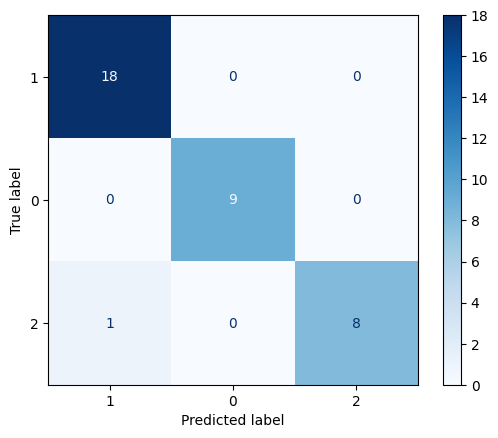

In [59]:
# We next display the confusion matrix.
labels = y_pred.unique()
cm = confusion_matrix(df.tail(36)['Y'], y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.show()

- Class 1 (Perfect Performance): 18 times, the model correctly predicted "Class 1" when the true label was "Class 1". The model never incorrectly predicted another class as "Class 1" (the "1" column only has a number in the "1" row).

- Class 0 (Perfect Performance): 9 times, the model correctly predicted "Class 0" when the true label was "Class 0". The model never incorrectly predicted another class as "Class 0".

- Class 2 (One Error): 8 times, the model correctly predicted "Class 2" when the true label was "Class 2". 1 time, the model made an error: The true label was "Class 2", but the model incorrectly predicted it as "Class 1".

In [56]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(df.tail(36)['Y'], y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.95      1.00      0.97        18
           2       1.00      0.89      0.94         9

    accuracy                           0.97        36
   macro avg       0.98      0.96      0.97        36
weighted avg       0.97      0.97      0.97        36



- Class 0: Achieved perfect precision, recall, and F1-score (1.00), indicating the model correctly identified all instances of Class 0 and did not misclassify any other class as Class 0.
- Class 1: Showed high precision (0.95), perfect recall (1.00), and a high F1-score (0.97), indicating excellent performance with no false negatives for this class.
- Class 2: Had perfect precision (1.00), but slightly lower recall (0.89), resulting in a good F1-score (0.94). This means while all predictions of Class 2 were correct, some actual Class 2 instances were missed.

- Accuracy (0.97): This indicates that the model correctly predicted the class for 97% of the data points in the test set. It's a general measure of how well the model performed across all classes. It is very good.
- Macro Avg (precision 0.98, recall 0.96, f1-score 0.97): The macro average calculates the average of the precision, recall, and F1-score for each class, treating all classes equally. This gives an idea of the performance on each class independently, without being influenced by how many samples are in each class.
- Weighted Avg (precision 0.97, recall 0.97, f1-score 0.97): The weighted average also calculates the average of precision, recall, and F1-score, but it weights the contribution of each class by the number of samples in that class (support). This metric is more representative of the model's performance on the dataset as a whole, especially if there is an imbalance in the number of samples per class.

# 4. Predict New Data Points

● Create two new data points with realistic values (refer to the dataset's feature ranges). (look at the pdf picture)

● Use your PRISM model to predict their class labels.

● Provide a detailed explanation for each prediction:
- Which rule(s) applied to this data point?
- Why does PRISM classify it as that class?

Example: “The new sample has high alcohol and high proline, which matches rule for class 0.”


In [58]:
# Create new data points for the dataset
# You can change these values to test different scenarios
new_data = {
  'alcohol': [14.0, 14.00],
  'malic_acid': [2.0, 2.0],
  'ash': [2.3, 2.2],
  'alcalinity_of_ash': [19.0, 11.0],
  'magnesium': [95.0, 95.0],
  'total_phenols': [2.2, 2.5],
  'flavanoids': [0.14, 0.5],
  'nonflavanoid_phenols': [0.14, 0.5],
  'proanthocyanins': [1.6, 1.5],
  'color_intensity': [7.0, 6.0],
  'hue': [0.7, 0.6],
  'od280/od315_of_diluted_wines': [3.2, 3.0],
  'proline': [550.0, 1400.0]
}

new_df = pd.DataFrame(new_data)

# Predict on the new data using the prism model trained on data
prediction = prism.predict(new_df)
# Assign predictions to a new column in the DataFrame
new_df['Predicted Class'] = prediction

# Display the new data and prediction
print("New Data Points:")
display(new_df)

New Data Points:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Predicted Class
0,14.0,2.0,2.3,19.0,95.0,2.2,0.14,0.14,1.6,7.0,0.7,3.2,550.0,1
1,14.0,2.0,2.2,11.0,95.0,2.5,0.50,0.50,1.5,6.0,0.6,3.0,1400.0,0


**New Data Point 1:**

*   **Data:** alcohol: 14.0, malic_acid: 2.0, ash: 2.3, alcalinity_of_ash: 19.0, magnesium: 95.0, total_phenols: 2.2, flavanoids: 0.14, nonflavanoid_phenols: 0.14, proanthocyanins: 1.6, color_intensity: 7.0, hue: 0.7, od280/od315_of_diluted_wines: 3.2, proline: 550.0
*   **Predicted Class:** 1
*   **Explanation:**
    *   Let's look at the relevant features for the rules:
        *   `alcohol` (14.0) falls into the 'High' bin (13.49 - 14.83).
        *   `color_intensity` (7.0) falls into the 'High' bin (5.70 - 11.75).
        *   `flavanoids` (0.14) falls into the 'Low' bin (0.34 - 1.46).
        *   `hue` (0.7) falls into the 'Low' bin (0.48 - 0.87).
        *   `od280/od315_of_diluted_wines` (3.2) falls into the 'High' bin (3.02 - 4.00).
        *   `proline` (550.0) falls into the 'Low' bin (278.00 - 560.00).
    *   Now let's check the rules:
        *   **Rule for Target Class 2:** If flavanoids = Low AND color_intensity = Med (This data point has flavanoids = Low but color_intensity = High, so this rule does not apply).
        *   **Second Rule for Target Class 2:** If od280/od315_of_diluted_wines = Low AND color_intensity = High AND hue = Low (This data point has od280/od315_of_diluted_wines = High, so this rule does not apply).
        *   **Rule for Target Class 1:** If color_intensity = Low AND alcohol = Low (This data point has color_intensity = High and alcohol = High, so this rule does not apply).
        *   **Second Rule for Target Class 1:** If proline = Low AND alcohol = Med (This data point has proline = Low but alcohol = High, so this rule does not apply).
        *   **Rule for Target Class 0:** If proline = High AND alcohol = High (This data point has proline = Low, so this rule does not apply).
        *   **Second Rule for Target Class 0:** If proline = High AND alcohol = Med (This data point has proline = Low and alcohol = High, so this rule does not apply).

    *   Based on the rules generated, none of the specific rules for classes 0, 1, or 2 are perfectly matched by this data point. In such cases, the PRISM model typically assigns the instance to the majority class of the remaining data not covered by the rules, or a default class. In this specific case, based on the prediction output being Class 1, it is likely that after checking all the specific rules, Class 1 was the default or most probable class assigned by the model for this combination of features.

**New Data Point 2:**

*   **Data:** alcohol: 14.0, malic_acid: 2.0, ash: 2.2, alcalinity_of_ash: 11.0, magnesium: 95.0, total_phenols: 2.5, flavanoids: 0.50, nonflavanoid_phenols: 0.50, proanthocyanins: 1.5, color_intensity: 6.0, hue: 0.6, od280/od315_of_diluted_wines: 3.0, proline: 1400.0
*   **Predicted Class:** 0
*   **Explanation:**
    *   Let's look at the relevant features for the rules:
        *   `alcohol` (14.0) falls into the 'High' bin (13.49 - 14.83).
        *   `color_intensity` (6.0) falls into the 'High' bin (5.70 - 11.75).
        *   `flavanoids` (0.50) falls into the 'Low' bin (0.34 - 1.46).
        *   `hue` (0.6) falls into the 'Low' bin (0.48 - 0.87).
        *   `od280/od315_of_diluted_wines` (3.0) falls into the 'Med' bin (2.23 - 3.02).
        *   `proline` (1400.0) falls into the 'High' bin (845.00 - 1680.00).
    *   Now let's check the rules:
        *   **Rule for Target Class 0:** If proline = High AND alcohol = High. This data point has proline = High and alcohol = High. This rule matches!

    *   **Why does PRISM classify it as Class 0?** This data point matches the rule "If proline = High AND alcohol = High". This rule has a support of 100% for Class 0, meaning all training data points matching this rule belonged to Class 0. Therefore, PRISM classifies this new data point as Class 0 based on this matched rule.

Jevon Ivander K / 0706022310028